## Apprentissage supervisé: Forêts d'arbres aléatoires (Random Forests)

Intéressons nous maintenant à un des algorithmes les plus popualires de l'état de l'art. Cet algorithme est non-paramétrique et porte le nom de **forêts d'arbres aléatoires**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


## A l'origine des forêts d'arbres aléatoires : l'arbre de décision

Les fôrets aléatoires appartiennent à la famille des méthodes d'**apprentissage ensembliste** et sont construits à partir d'**arbres de décision**. Pour cette raison, nous allons tout d'abord présenter les arbres de décisions.

Un arbre de décision est une manière très intuitive de résoudre un problème de classification. On se contente de définir un certain nombre de questions qui vont permetre d'identifier la classe adéquate.

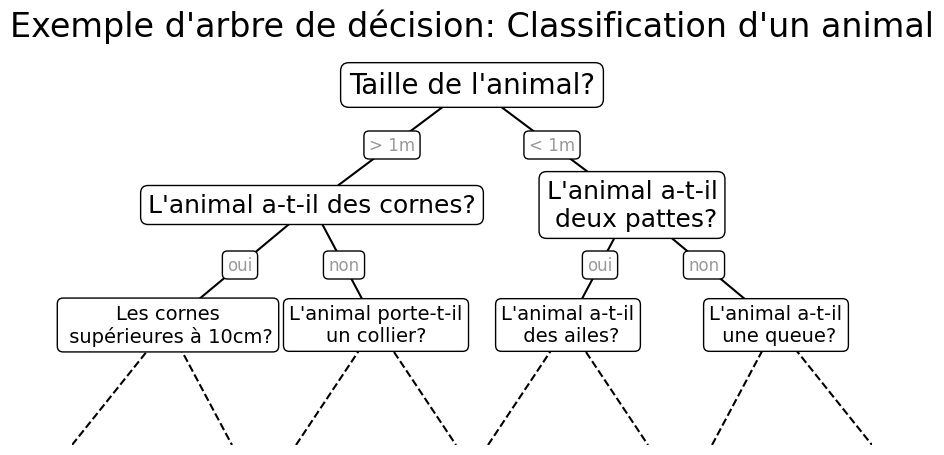

In [2]:
import fig_code.figures as fig
fig.plot_example_decision_tree()

Le découpage binaire des données est rapide à mettre en oeuvre. La difficulté va résider dans la manière de déterminer quelle est la "bonne" question à poser.

C'est tout l'enjeu de la phase d'apprentissage d'un arbre de décision. L'algorithme va déterminer, au vu d'un ensemble de données, quelle question (ou découpage...) va apporter le plus gros gain d'information.

### Construction d'un arbre de décision
Voici un exemple de classifieur à partir d'un arbre de décision en utlisiant `Scikit-Learn`.

Nous commencons par définir un jeu de données en 2 dimensions avec des labels associés:

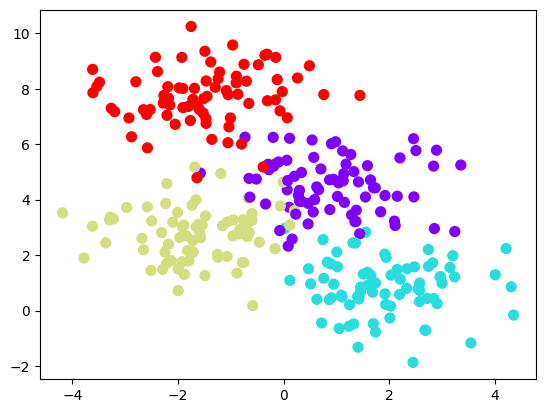

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Nous avons précemment défini une fonction qui va faciliter la visualisation du processus :

In [4]:
from fig_code.figures import visualize_tree, plot_tree_interactive

On utilise maintenant la fonction `plot_tree_interactive` pour visualiser les découpages effectués par l'arbre de décision en fonction de la profondeur de l'arbre (*depth* en anglais), i.e. le nombre de questions que l'arbre peut poser à la suite:

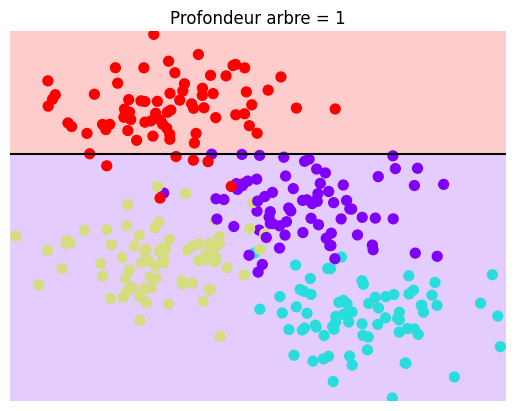

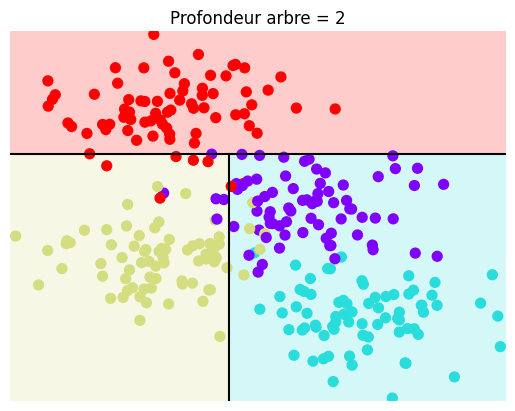

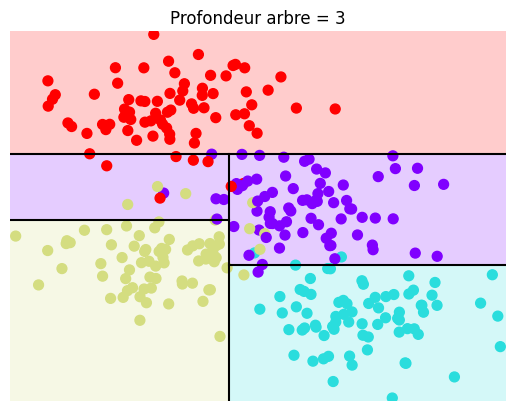

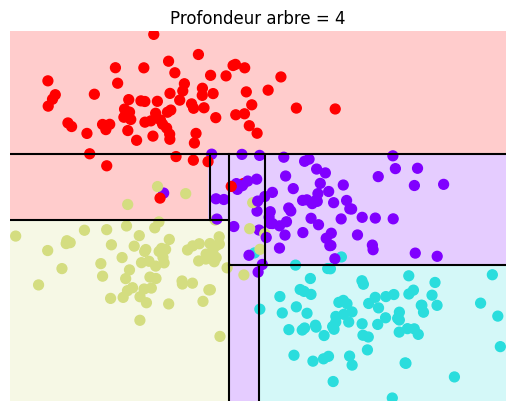

In [5]:
for profondeur_arbre in range(1,5):
    plot_tree_interactive(X, y, profondeur_arbre);
    plt.title("Profondeur arbre = " +str(profondeur_arbre))
    plt.show()

**Remarque** : à chaque augmentation de la profondeur de l'arbre, chaque branche est découpée en deux **à l'expection** des branches qui contiennent uniquement des points d'une unique classe.

L'arbre de décision est une méthode de classification non paramétrique facile à mettre en oeuvre

**Question: Observez-vous des problèmes avec cette modélisation ?**

## Arbre de décision et sur-apprentissage

Un problème avec les arbres de décision est qu'ils ont tendance à **sur-apprendre** rapidement sur les données d'apprentissage. En effet, ils ont une forte tendance à capturer le bruit présent dans les données plutôt que la vraie distribution recherchée. Par exemple, si on construit 2 arbres à partir de sous ensembles des données définies précédemment, on obtient les deux classifieurs suivants:

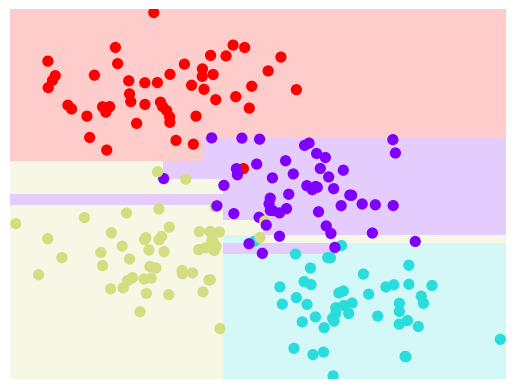

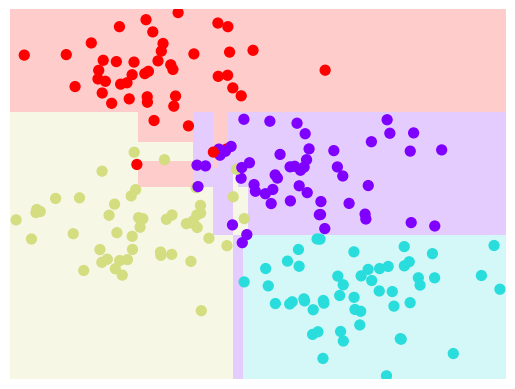

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

visualize_tree(clf, X[:200], y[:200], boundaries=False)
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

Les 2 classifieurs ont des différences notables si on regarde en détails les figures. Lorsque'on va prédire la classe d'un nouveau point, cela risque d'être impacté par le bruit dans les données plus que par le signal que l'on cherche à modéliser.


## Prédictions ensemblistes: Forêts aléatoires
Une façon de limiter ce problème de sur-apprentissage est d'utiliser un **modèle ensembliste**: un méta-estimateur qui va aggréger les predictions de mutliples estimateurs (qui peuvent sur-apprendre individuellement). Grace à des propriétés mathématiques plutôt magiques (!), la prédiction aggrégée de ces estimateurs s'avère plus performante et robuste que les performances des estimateurs considérés individuellement.

Une des méthodes ensemblistes les plus célèbres est la méthode des **forêts d'arbres aléatoires** qui aggrège les prédictions de multiples arbres de décision.

Il y a beaucoup de littérature scientifique pour déterminer la façon de rendre aléatoires ces arbres, voici une façon d'utiliser un sous échantillon des données:


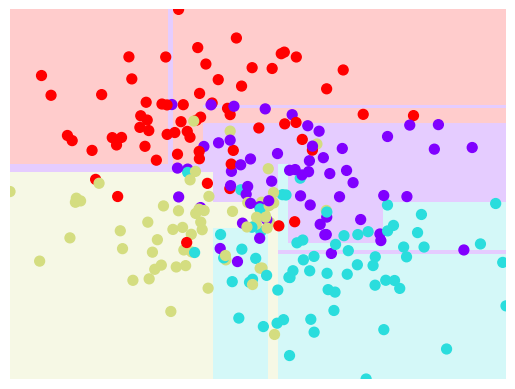

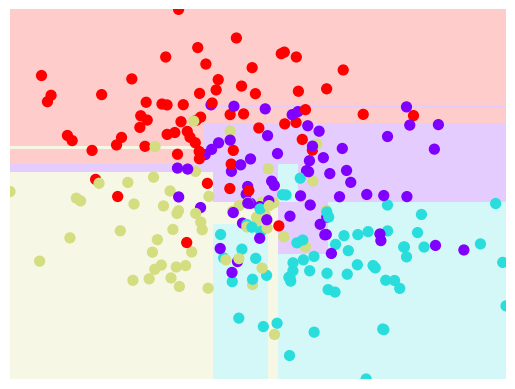

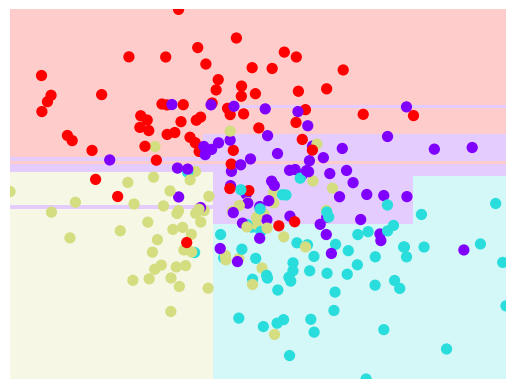

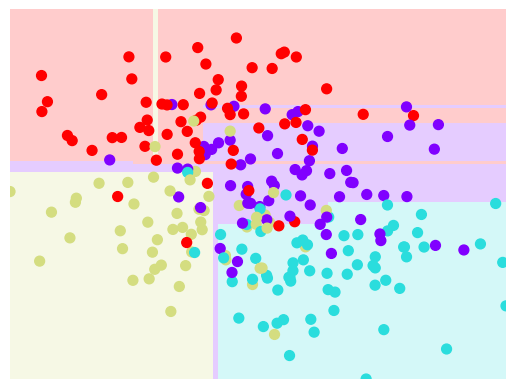

In [7]:
X, y = make_blobs(
    n_samples=300,
    centers=4,
    random_state=0,
    cluster_std=2.0
)

def fit_randomized_tree(random_state: int=0) -> None:
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    
    clf = DecisionTreeClassifier(max_depth=5)
    #on utilise seulement 250 exemples choisis aléatoirement sur les 300 disponibles
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))

for rand_state in [1, 7, 8, 10]:
    # on effectue 4 tirages aléatoires différents 
    fit_randomized_tree(random_state=rand_state)

On peut observer dans le détail les changements du modèle en fonction du tirage aléatoire des données qu'il utilise pour l'apprentissage, alors que la distribution des données est figée !

La forêt aléatoire va faire des caluls similaires, mais va aggréger l'ensemble des arbres aléatoires générés pour construire une unique prédiction:

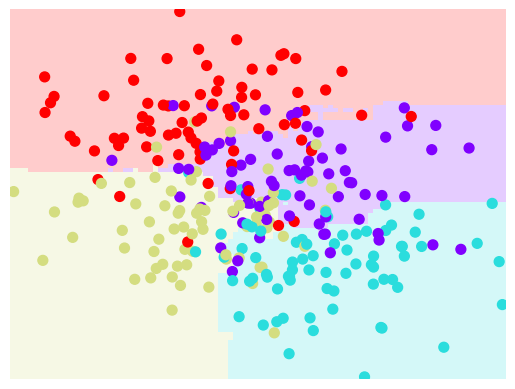

In [8]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
visualize_tree(clf, X, y, boundaries=False);

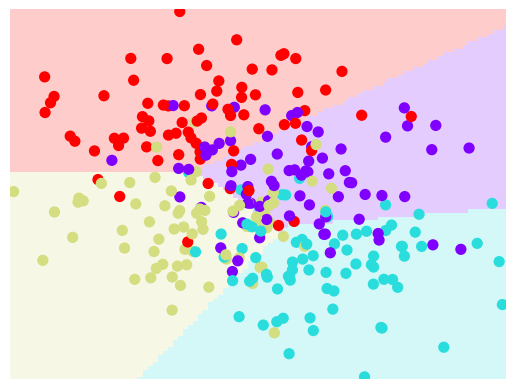

In [9]:
from sklearn.svm import SVC  
clf = SVC(kernel='linear')
clf.fit(X, y)
visualize_tree(clf,X, y, boundaries=False)
plt.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=200,
    facecolors='none'
);

En moyennant 100 arbres de décision "perturbés" aléatoirement, nous obtenons une prédiction aggrégé qui modélise avec plus de justesse nos données.

**Remarque**: ci dessus, notre perturbation aléatoire est effectué en echantillonant de manière aléatoire nos données... Les arbres aléatoires utilisent des techniques plus sophistiquées, pour plus de détails voir la [documentation de scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html#forest)

### Application à un problème de régression
On considère pour cet exemple un cas d'tétude différent des exemples précédent de classification. Les arbres aléatoires peuvent être également utilisés sur des problèmes de régression (c'est à dire la prédiction d'une variable continue plutôt que discrète).

L'estimateur que nous utiliserons est le suivant: ``sklearn.ensemble.RandomForestRegressor``.

Nous présentons rapidement comment il peut être utilisé:

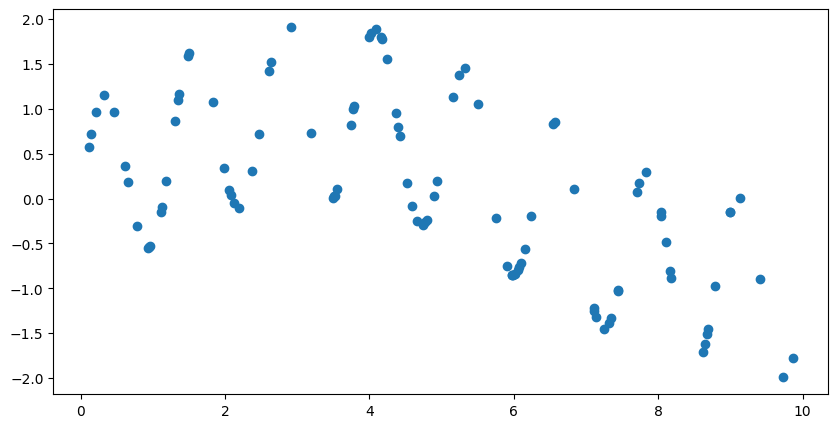

In [10]:
from sklearn.ensemble import RandomForestRegressor
# On commence par créer un jeu de données d'apprentissage
x = 10 * np.random.rand(100)

def model(x, sigma=0.):
    # sigma controle le bruit 
    # sigma=0 pour avoir une distribution "parfaite"
    oscillation_rapide = np.sin(5 * x)
    oscillation_lente = np.sin(0.5 * x)
    bruit = sigma * np.random.randn(len(x))

    return oscillation_rapide + oscillation_lente + bruit

y = model(x)
plt.figure(figsize=(10,5))
plt.scatter(x, y);

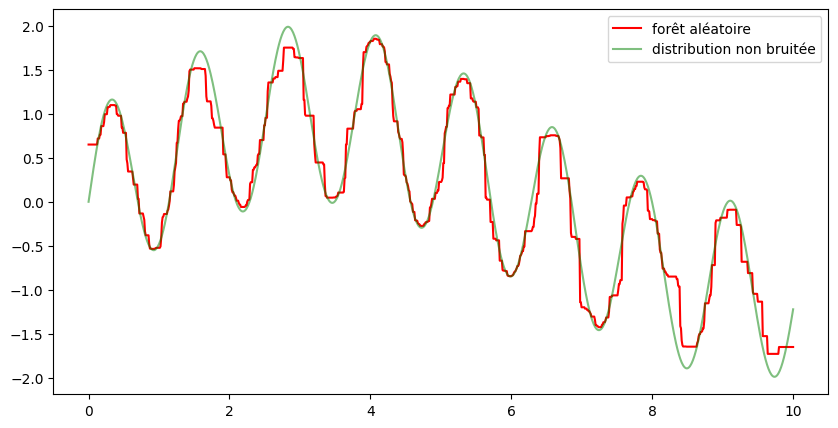

In [11]:
xfit = np.linspace(0, 10, num=1000)
# yfit contient les prédictions de la forêt aléatoire à partir des données bruités
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None])
# ytrue contient les valuers du modèle qui génèrent nos données avec un bruit nul 
ytrue = model(xfit, sigma=0) 

plt.figure(figsize=(10,5))
#plt.scatter(x, y)
plt.plot(xfit, yfit, '-r', label = 'forêt aléatoire')
plt.plot(xfit, ytrue, '-g', alpha=0.5, label = 'distribution non bruitée')
plt.legend();

On observe que les forêts aléatoires, de manière non-paramétrique, arrivent à estimer une distribution avec de mutliples périodicités sans aucune intervention de notre part pour définir ces périodicités !

### La recherche des meilleurs hyperparamètres

Il existe, pour chaque famille d'algorithme, un certain nombre d'hyperparamètres. Or, pour des raisons de coût de calcul évident, il n'est pas possible d'explorer toutes les combinaisons possibles. Il est donc conseillé de partir de la configuration par défaut de `Scikit-Learn` puis d'adapter ces hyperparamètres à son problème (taille du jeu de données, équilibrage du jeu de données, prédicteurs, ...).

Pour connaitre la liste des arguments d'un objet python (ce qui correspond aux hyperparamètres de notre `Estimator`), il suffit de regarder la documentation ou d'ajouter un `?` à la suite de votre objet dans une console `Ipython`

In [12]:
RandomForestRegressor?

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of decision tree
regressors on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is use

Quelle sont les options disponibles  pour le ``RandomForestRegressor``?

Quelle influence sur le graphique précédent si on modifie ces valeurs?

**Remarque:** Il est impossible de garantir qu'un ensemble d'hyperparamètres est le meilleur pour résoudre un problème, par contre en réalisant quelques tests on peut facilement trouver un minimum local convenable.